In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pylab as p
import matplotlib.pyplot as plot
from collections import Counter
import re

#importing packages for the prediction of time-series data
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error

In [2]:
# Read using pandas:
df = pd.read_csv("./BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",parse_dates=['Date'],index_col=['Date'])
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns={"Closing Price (USD)":"Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


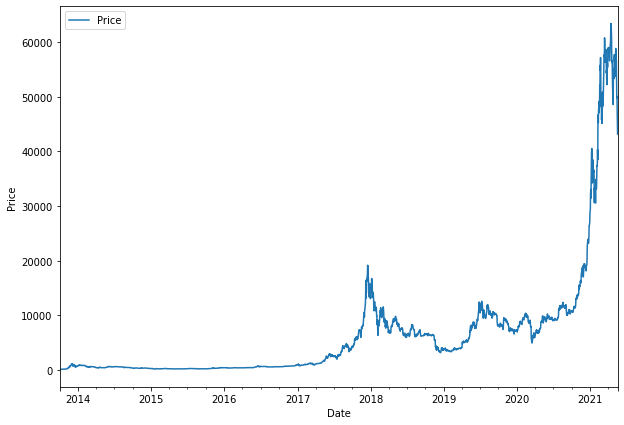

In [5]:
import matplotlib.pyplot as plot
bitcoin_prices.plot(figsize=(10,7))
plot.ylabel('Price');

### Testing stationarity

- Augmented Dicky Fuller test 
1. Used to determine whether a TS is stationary or not.
2. It is a statistical test where the null hypothesis is that the coefficient of first
lag is 1, i.e. presence of a unit root, in this case the TS is not stationary.
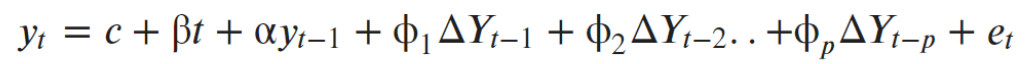
3. Null hypothesis is that the value of alpha is 1, so we need p-value less than significance level to reject it.
4. If the null hypothesis is rejected, we say that TS is stationary.

In [8]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(x):


    #Determing rolling statistics
    rolmean = x.rolling(window=22,center=False).mean()

    rolstd = x.rolling(window=12,center=False).std()
    
    #Plot rolling statistics:
    orig = plot.plot(x, color='blue',label='Original')
    mean = plot.plot(rolmean, color='red', label='Rolling Mean')
    std = plot.plot(rolstd, color='black', label = 'Rolling Std')
    plot.legend(loc='best')
    plot.title('Rolling Mean & Standard Deviation')
    plot.show(block=False)
    
    #Perform Dickey Fuller test    
    result=adfuller(x)
    print('ADF Stastistic: %f'%result[0])
    print('p-value: %f'%result[1])
    pvalue=result[1]
    for key,value in result[4].items():
         if result[0]>value:
            print("The graph is non stationery")
            break
         else:
            print("The graph is stationery")
            break;
    print('Critical values:')
    for key,value in result[4].items():
        print('\t%s: %.3f ' % (key, value))

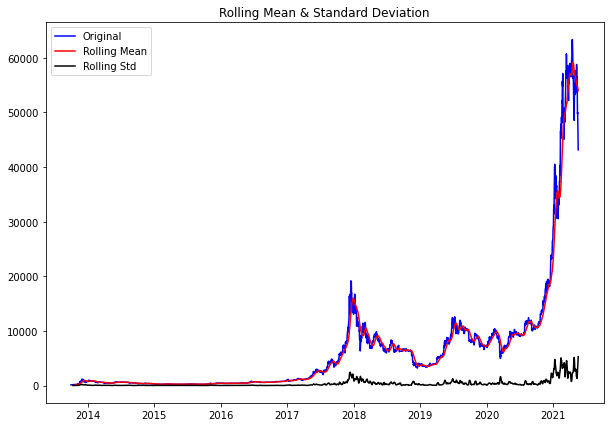

ADF Stastistic: -0.481790
p-value: 0.895521
The graph is non stationery
Critical values:
	1%: -3.433 
	5%: -2.863 
	10%: -2.567 


In [9]:
plot.figure(figsize=(10,7))
ts = bitcoin_prices['Price']      
test_stationarity(ts)

### Log transformation

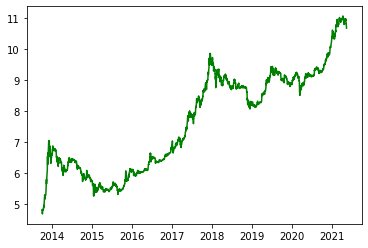

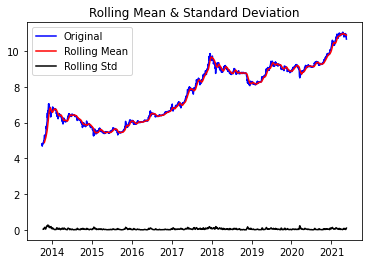

ADF Stastistic: -0.784754
p-value: 0.823559
The graph is non stationery
Critical values:
	1%: -3.433 
	5%: -2.863 
	10%: -2.567 


In [10]:
ts_log = np.log(ts)
plot.plot(ts_log,color="green")
plot.show()

test_stationarity(ts_log)

### Removing trend and seasonality with differencing

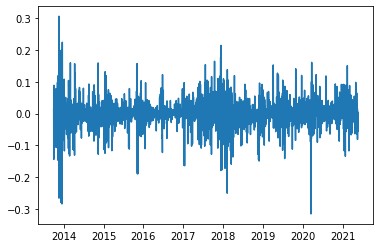

In [11]:
ts_log_diff = ts_log - ts_log.shift()
plot.plot(ts_log_diff)
plot.show()

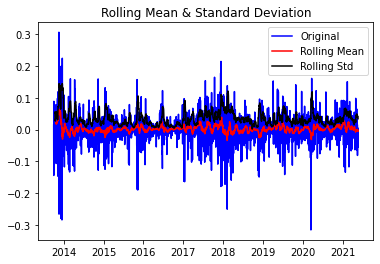

ADF Stastistic: -13.923977
p-value: 0.000000
The graph is stationery
Critical values:
	1%: -3.433 
	5%: -2.863 
	10%: -2.567 


In [12]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

### Time to apply forecasting models
- AR model
- MA model
- ARIMA model

#### AR model

D:\anaconda_dist\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda_dist\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda_dist\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


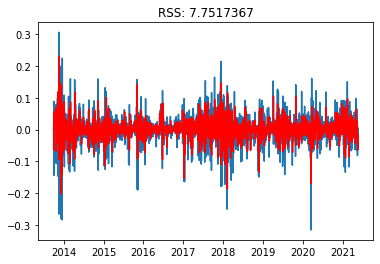

In [14]:
ar_model = ARIMA(ts_log_diff, order=(1,1,0))  
results_ARIMA = ar_model.fit()  
plot.plot(ts_log_diff)
plot.plot(results_ARIMA.fittedvalues, color='red')
# print(results_ARIMA.fittedvalues.values)
# print(ts_log_diff.values)
plot.title('RSS: %.7f'% sum((results_ARIMA.fittedvalues.values-ts_log_diff.values)**2))
plot.show()

#### MA model

D:\anaconda_dist\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda_dist\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda_dist\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


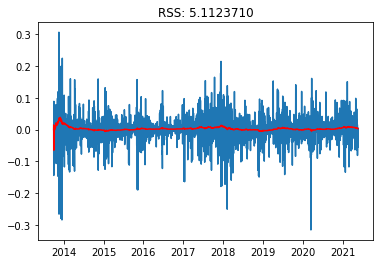

In [15]:
ma_model = ARIMA(ts_log_diff, order=(0,1,1))  
results_ARIMA = ma_model.fit()  
plot.plot(ts_log_diff)
plot.plot(results_ARIMA.fittedvalues, color='red')
# print(results_ARIMA.fittedvalues.values)
# print(ts_log_diff.values)
plot.title('RSS: %.7f'% sum((results_ARIMA.fittedvalues.values-ts_log_diff.values)**2))
plot.show()

##### ARIMA model

D:\anaconda_dist\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda_dist\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda_dist\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


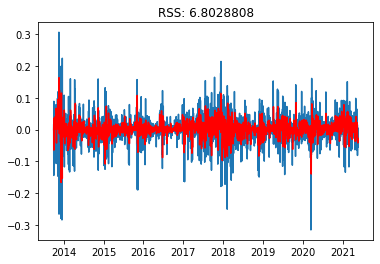

In [16]:
arima_model = ARIMA(ts_log_diff, order=(2,1,0))  
results_ARIMA = arima_model.fit()  
plot.plot(ts_log_diff)
plot.plot(results_ARIMA.fittedvalues, color='red')
# print(results_ARIMA.fittedvalues.values)
# print(ts_log_diff.values)
plot.title('RSS: %.7f'% sum((results_ARIMA.fittedvalues.values-ts_log_diff.values)**2))
plot.show()

In [17]:
size = int(len(ts_log)-100)
# Divide into train and test
train_arima, test_arima = ts_log[0:size], ts_log[size:len(ts_log)]
history = [x for x in train_arima]
predictions = list()
originals = list()
error_list = list()

def predict_func(p,d,q):
    print('Printing Predicted vs Expected Values...')
    print('\n')
    # We go over each value in the test set and then apply ARIMA model and calculate the predicted value. We have the expected value in the test set therefore we calculate the error between predicted and expected value 
    for t in range(len(test_arima)):
        model = ARIMA(history, order=(p, d, q))
        model_fit = model.fit()

        output = model_fit.forecast()

        pred_value = output[0]


        original_value = test_arima[t]
        history.append(original_value)

        pred_value = np.exp(pred_value)


        original_value = np.exp(original_value)

        # Calculating the error
        error = ((abs(pred_value - original_value)) / original_value) * 100
        error_list.append(error)
        print('predicted = %f,   expected = %f,   error = %f ' % (pred_value, original_value, error), '%')

        predictions.append(float(pred_value))
        originals.append(float(original_value))

    # After iterating over whole test set the overall mean error is calculated.   
    print('\n Mean Error in Predicting Test Case Articles : %f ' % (sum(error_list)/float(len(error_list))), '%')
    plot.figure(figsize=(8, 6))
    test_day = [t
               for t in range(len(test_arima))]
    labels={'Orginal','Predicted'}
    plot.plot(test_day, predictions, color= 'green')
    plot.plot(test_day, originals, color = 'orange')
    plot.title('Expected Vs Predicted Views Forecasting')
    plot.xlabel('Day')
    plot.ylabel('Closing Price')
    plot.legend(labels)
    plot.show()

Printing Predicted vs Expected Values...


predicted = 40271.231702,   expected = 38461.681403,   error = 4.704813  %
predicted = 38484.746664,   expected = 44716.685469,   error = 13.936495  %
predicted = 44619.639832,   expected = 46674.851688,   error = 4.403253  %
predicted = 46647.516824,   expected = 45237.475689,   error = 3.116976  %
predicted = 45256.002857,   expected = 47500.897524,   error = 4.726005  %
predicted = 47469.575137,   expected = 47884.182862,   error = 0.865855  %
predicted = 47878.548425,   expected = 47005.190649,   error = 1.858003  %
predicted = 47016.933075,   expected = 49151.167576,   error = 4.342185  %
predicted = 49121.221990,   expected = 48125.992195,   error = 2.067967  %
predicted = 48139.699324,   expected = 48840.414475,   error = 1.434704  %
predicted = 48830.548254,   expected = 52165.302555,   error = 6.392667  %
predicted = 52117.871034,   expected = 51728.508797,   error = 0.752703  %
predicted = 51733.885345,   expected = 55719.204362,   e

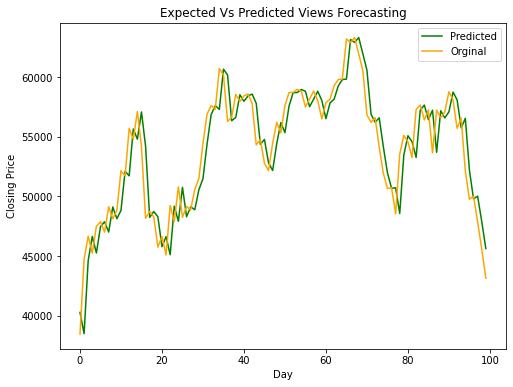

In [18]:
predict_func(0,1,1)# MA

Printing Predicted vs Expected Values...


predicted = 43217.569240,   expected = 38461.681403,   error = 12.365262  %
predicted = 38562.193446,   expected = 44716.685469,   error = 13.763301  %
predicted = 44665.999539,   expected = 46674.851688,   error = 4.303928  %
predicted = 46522.759573,   expected = 45237.475689,   error = 2.841193  %
predicted = 45229.829756,   expected = 47500.897524,   error = 4.781105  %
predicted = 47482.822522,   expected = 47884.182862,   error = 0.838190  %
predicted = 47837.353395,   expected = 47005.190649,   error = 1.770364  %
predicted = 47014.907474,   expected = 49151.167576,   error = 4.346306  %
predicted = 49125.578299,   expected = 48125.992195,   error = 2.077019  %
predicted = 48108.645655,   expected = 48840.414475,   error = 1.498285  %
predicted = 48844.127689,   expected = 52165.302555,   error = 6.366636  %
predicted = 52087.556341,   expected = 51728.508797,   error = 0.694100  %
predicted = 51678.248637,   expected = 55719.204362,   

D:\anaconda_dist\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 50561.695816,   expected = 51503.258132,   error = 1.828161  %
predicted = 51459.373845,   expected = 54458.037811,   error = 5.506375  %


D:\anaconda_dist\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 54381.803438,   expected = 56915.173935,   error = 4.451134  %
predicted = 56821.924936,   expected = 57636.757962,   error = 1.413738  %
predicted = 57588.625115,   expected = 57306.166263,   error = 0.492894  %
predicted = 57303.289267,   expected = 60743.041825,   error = 5.662793  %
predicted = 60675.950302,   expected = 60197.901992,   error = 0.794128  %
predicted = 60163.159476,   expected = 56300.334109,   error = 6.861106  %
predicted = 56383.728166,   expected = 56639.783950,   error = 0.452078  %


D:\anaconda_dist\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 56685.257813,   expected = 58567.283781,   error = 3.213442  %
predicted = 58522.537330,   expected = 57983.094744,   error = 0.930345  %
predicted = 57967.279383,   expected = 58451.731466,   error = 0.828807  %
predicted = 58450.468976,   expected = 58593.602454,   error = 0.244282  %
predicted = 58584.015888,   expected = 57796.467371,   error = 1.362624  %
predicted = 57810.596143,   expected = 54329.358635,   error = 6.407654  %
predicted = 54407.898085,   expected = 54794.297714,   error = 0.705182  %
predicted = 54833.192781,   expected = 52787.745526,   error = 3.874852  %
predicted = 52821.589761,   expected = 52173.867980,   error = 1.241468  %
predicted = 52213.161552,   expected = 54483.045732,   error = 4.166221  %
predicted = 54444.056434,   expected = 56234.356105,   error = 3.183640  %


D:\anaconda_dist\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 56164.075950,   expected = 55343.925815,   error = 1.481915  %
predicted = 55336.654000,   expected = 57627.679249,   error = 3.975564  %
predicted = 57593.359781,   expected = 58734.475434,   error = 1.942838  %
predicted = 58678.407668,   expected = 58724.664517,   error = 0.078769  %
predicted = 58709.070820,   expected = 58984.612930,   error = 0.467142  %
predicted = 58979.505884,   expected = 58821.626994,   error = 0.268403  %
predicted = 58821.236675,   expected = 57517.798773,   error = 2.266147  %
predicted = 57546.007198,   expected = 58177.402764,   error = 1.085293  %
predicted = 58182.465146,   expected = 58843.559540,   error = 1.123478  %
predicted = 58820.539748,   expected = 58040.187602,   error = 1.344503  %
predicted = 58046.891464,   expected = 56508.942864,   error = 2.721602  %
predicted = 56550.438115,   expected = 57880.905684,   error = 2.298629  %
predicted = 57875.011632,   expected = 58171.909019,   error = 0.510379  %
predicted = 58145.965956,

D:\anaconda_dist\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 50721.945843,   expected = 50733.769504,   error = 0.023305  %
predicted = 50749.910991,   expected = 48542.952203,   error = 4.546404  %
predicted = 48583.256529,   expected = 53558.707845,   error = 9.289715  %
predicted = 53484.919773,   expected = 55123.861981,   error = 2.973199  %
predicted = 55019.445430,   expected = 54591.515326,   error = 0.783877  %
predicted = 54580.249460,   expected = 53260.295341,   error = 2.478308  %
predicted = 53293.047918,   expected = 57302.646424,   error = 6.997231  %
predicted = 57239.512226,   expected = 57677.975222,   error = 0.760191  %
predicted = 57611.351072,   expected = 56427.043125,   error = 2.098830  %
predicted = 56446.167721,   expected = 57255.306838,   error = 1.413212  %
predicted = 57256.775478,   expected = 53658.843121,   error = 6.705199  %
predicted = 53717.359417,   expected = 57252.702185,   error = 6.174980  %
predicted = 57227.302165,   expected = 56583.849879,   error = 1.137166  %
predicted = 56547.308112,

ValueError: x and y must have same first dimension, but have shapes (100,) and (200,)

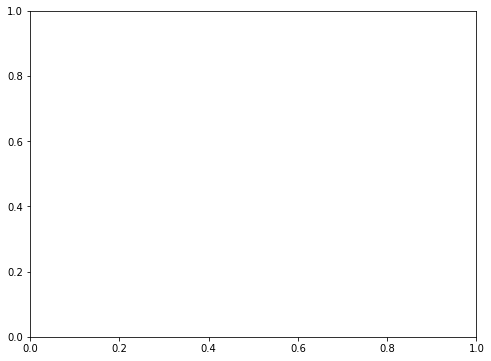

In [19]:
predict_func(2,1,0)# ARIMA